In [1]:
import torch
import torch_geometric
import matplotlib.pyplot as plt
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
import MyData as data
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score
from torch_geometric.loader import DataLoader
import ROOT
import numpy as np
from matplotlib.lines import Line2D
import pandas as pd
import array as ary
import GNN_model

ERROR in cling::CIFactory::createCI(): cannot extract standard library include paths!
Invoking:
  x86_64-conda_cos6-linux-gnu-c++  -O3 -DNDEBUG -xc++ -E -v /dev/null 2>&1 | sed -n -e '/^.include/,${' -e '/^ \/.*++/p' -e '}'
Results was:
With exit code 0


Welcome to JupyROOT 6.20/02


In [3]:
sel_alg=0
view='xz'

In [4]:
if sel_alg==3:
    num_ly=3
    num_to_reduce=64
    hidden_size = num_to_reduce*num_ly

In [5]:
model_list=['SageConv','SageConv2','GCN','GCN_2','GAT','GDPModel']

In [6]:
NUM_FEATURES=5
NUM_CLASSES=1

In [7]:
if sel_alg>len(model_list):
    print('no algorithm available')
if sel_alg==0:
    model = GNN_model.SageConv(num_feat=NUM_FEATURES,num_class=NUM_CLASSES)
elif sel_alg==1:
    model = GNN_model.SageConv2(num_feat=NUM_FEATURES,num_class=NUM_CLASSES)
elif sel_alg==2:
    model = GNN_model.GCN(num_feat=NUM_FEATURES, num_class=NUM_CLASSES,num_to_reduce=64)
elif sel_alg==3:
    model = GNN_model.GCN_2(hidden_size=hidden_size, num_ly=num_ly, num_feat=NUM_FEATURES, num_class=NUM_CLASSES,num_to_reduce=64)
elif sel_alg==4:
    model = GNN_model.GAT(num_feat=NUM_FEATURES, num_class=NUM_CLASSES)
elif sel_alg==5:
    model = GNN_model.GDPModel()

In [8]:
data=data.dataset_preparation(root='/lustrehome/federicacuna/TestBeam_T10_2023/Data/')
if view=='xz':
    fname='pi-_10GeV_4ly_exp'
else:
    fname='pi-_10GeV_4ly_1e-4_yz'
    

In [9]:
data_trk=data.get(0,fname)

taking the  data_0.pt


In [8]:
print(len(data_trk))

108860


In [143]:
# %%time
# from torch.nn import Linear
# import torch.nn.functional as F
# from torch_geometric.nn import SAGEConv

# NUM_FEATURES = 5
# print(NUM_FEATURES)
# NUM_CLASSES =1
# HIDDEN_LAYER_SIZE = 256
# class SageConv(torch.nn.Module):
#     def __init__(self):
#         super().__init__()
#         # Model layers
#         self.conv1 = SAGEConv(NUM_FEATURES, HIDDEN_LAYER_SIZE)
#         self.conv2 = SAGEConv(HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE-64)
#         self.conv3 = SAGEConv(HIDDEN_LAYER_SIZE-64, NUM_CLASSES)
#         #self.lin_1 = Linear(HIDDEN_LAYER_SIZE, NUM_CLASSES*4)
#         #self.lin_2 = Linear(NUM_CLASSES*4, NUM_CLASSES)

#     def forward(self, data):
#         # The architecture itself
#         x, edge_index, batch = data.x, data.edge_index, data.batch
#         x = self.conv1(x, edge_index)
#         x = F.tanh(x)
#         x = self.conv2(x, edge_index)
#         x = F.relu(x)
#         x = self.conv3(x, edge_index)
       
#         #x = self.lin_1(x)
#        # x = F.tanh(x)
#         #x = self.lin_2(x)
#         return F.sigmoid(x)

5
CPU times: user 160 µs, sys: 52 µs, total: 212 µs
Wall time: 179 µs


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device=torch.device('cpu')
print('Using device:', device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')


Using device: cuda
NVIDIA A100-PCIE-40GB MIG 1g.5gb
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [11]:
if view=='xz':
    if sel_alg==0:
        best_model = torch.load("/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_pkl/optimized/NEWDATA_best_modelSageConv_lytrk4_view_xz_lr0_0001_epochs_500.pkl")
    elif sel_alg==3:
         best_model = torch.load("/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_pkl/optimized/best_modelGCN_2_lytrk4_view_xz_lr_5e-05_nepochs_1500_lentrain_2000000.pkl")       
    elif sel_alg==5:
        best_model = torch.load("/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_pkl/optimized/NEWDATAbest_model_gatedgenode_lytrk_4_view_xz_lr_0_0001_nepochs_600_len_2000000.pkl")
else:
    if sel_alg==0:
        best_model = torch.load("/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_pkl/optimized/NEWDATA_best_modelSageConv_lytrk4_view_yz_lr0_0001_epochs_500.pkl")
    elif sel_alg==3:
         best_model = torch.load("/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_pkl/optimized/best_modelGCN_2_lytrk4_view_yz_lr_5e-05_nepochs_1500_lentrain_2000000.pkl")       
    elif sel_alg==5:
        best_model = torch.load("/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_pkl/optimized/NEWDATAbest_model_gatedgenode_lytrk_4_view_yz_lr_0_0001_nepochs_600_len_2000000.pkl")

         
best_model.to(device) 

SageConv(
  (conv1): SAGEConv(5, 256, aggr=mean)
  (conv2): SAGEConv(256, 192, aggr=mean)
  (conv3): SAGEConv(192, 1, aggr=mean)
)

In [12]:
# ev_id=100
for i in range(0,10):
    test_batch=data_trk[i]
    print(i,' ',test_batch)

0   Data(x=[7, 5], edge_index=[2, 11], edge_attr=[11, 2])
1   Data(x=[7, 5], edge_index=[2, 11], edge_attr=[11, 2])
2   Data(x=[7, 5], edge_index=[2, 11], edge_attr=[11, 2])
3   Data(x=[11, 5], edge_index=[2, 29], edge_attr=[29, 2])
4   Data(x=[6, 5], edge_index=[2, 8], edge_attr=[8, 2])
5   Data(x=[6, 5], edge_index=[2, 8], edge_attr=[8, 2])
6   Data(x=[7, 5], edge_index=[2, 11], edge_attr=[11, 2])
7   Data(x=[6, 5], edge_index=[2, 8], edge_attr=[8, 2])
8   Data(x=[6, 5], edge_index=[2, 8], edge_attr=[8, 2])
9   Data(x=[7, 5], edge_index=[2, 11], edge_attr=[11, 2])


In [41]:
ev_id=5

test_batch=data_trk[ev_id]
print(ev_id,' ',test_batch)
test_batch.to(device) 
model_output = best_model(test_batch) 
model_output.to(device)
predicted_class = torch.where(model_output > 0.8, 1, 0)
# print(model_output)
predicted_class=predicted_class.detach().cpu().tolist()
predicted_class = [item for sublist in predicted_class for item in sublist]


5   Data(x=[7, 5], edge_index=[2, 11], edge_attr=[11, 2])


In [42]:
test_batch=test_batch.detach().cpu()
ly=test_batch.x[:,2]
x=test_batch.x[:,0]
z_hit=test_batch.x[:,3]
label=test_batch.y
label_pred=predicted_class
# print(x)
# print(label)
# print(label_pred)
# print(test_batch.x[:,4])

Text(0.5, 1.0, 'Ev 5: true label')

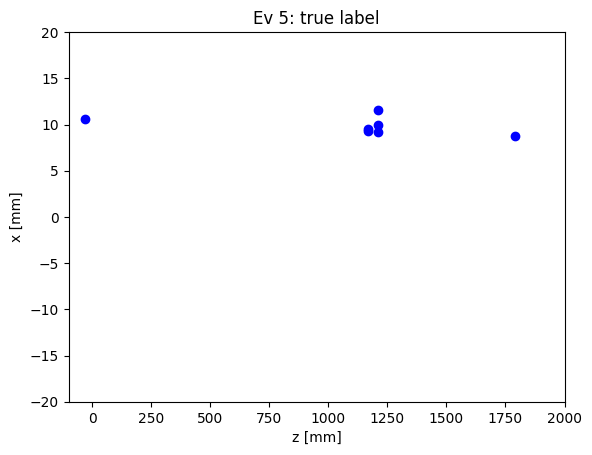

In [43]:
for i in range(len(x)):
    
    plt.scatter(z_hit[i],x[i], color='blue')
    
plt.xlim(-100,2000)
plt.ylim(-20,20)
plt.xlabel('z [mm]')
plt.ylabel('x [mm]')
plt.title(f'Ev {ev_id}: true label')


# plt.savefig(f'/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img/exp_data_trk/true_label_view_{view}_EXPev_{ev_id}_alg{model_list[sel_alg]}.png')

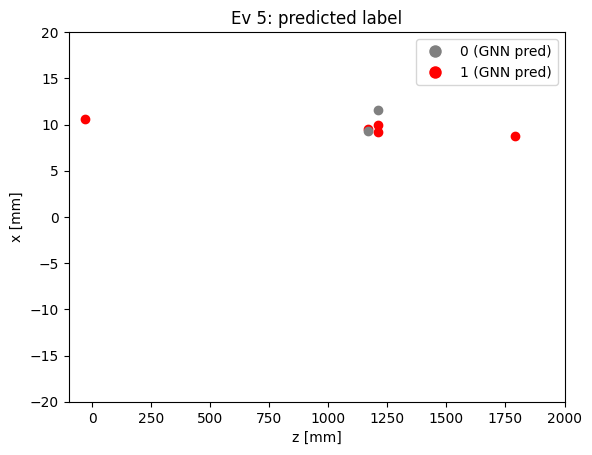

In [44]:
x_pred=[]
y_pred=[]
z_pred=[]
for i in range(len(x)):
    if label_pred[i] == 0:
        plt.scatter(z_hit[i],x[i], color='grey', label='0 (Pred)')
    else:
        x_pred.append(x[i].item())
        y_pred.append(ly[i].item())
        z_pred.append(z_hit[i].item())
        plt.scatter(z_hit[i],x[i], color='red', label='1 (Pred)')
        
plt.xlim(-100,2000)
plt.ylim(-20,20)
#plt.legend()
plt.ylabel('x [mm]')
plt.xlabel('z [mm]')
plt.title(f'Ev {ev_id}: predicted label')
legend_elements = [Line2D([0], [0], marker='o', color='w', label='0 (GNN pred)', markerfacecolor='grey', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='1 (GNN pred)', markerfacecolor='red', markersize=10)]

plt.legend(handles=legend_elements, loc='upper right')
plt.savefig(f'/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img/exp_data_trk/pred_label_view_{view}_EXPev_{ev_id}_alg{model_list[sel_alg]}.png')

In [13]:
# gr=ROOT.TGraph(len(np.array(x_pred)),np.array(x_pred),np.array(z_pred))
# c1=ROOT.TCanvas()
# c1.cd()
# gr.GetXaxis().SetLimits(-20.0,20.0);
# gr.GetXaxis().SetTitle('x [mm]')
# gr.GetYaxis().SetTitle('z [mm]')
# gr.SetMarkerStyle(8)
# gr.Draw('AP')
myfile=ROOT.TFile('/lustrehome/federicacuna/TB_Sept_2023_ml/root_file_predhit/pred_EXPdata_xz_sage_conv.root','RECREATE')
# gr.Write()
# c1.Write()

test_batch_ev=[]
for ev_id in range(0,len(data_trk)):
    test_batch_ev.append(data_trk[ev_id])
    predicted_class_ev=[]
    
for i in test_batch_ev:
    i.to(device)
    model_output = best_model(i) 
    
    predicted_class_ev.append((torch.where(model_output > 0.8, 1, 0)))

         
ly_ev=[]
x_ev=[]
z_ev=[]
pe_ev=[]
dx_ev=[]
no_good_ev=[]
for i in range(len(test_batch_ev)): 
        
    ev=test_batch_ev[i]
    ev=ev.detach().cpu()
    label = predicted_class_ev[i].detach().cpu().numpy()
    ly_ev.append([])
    x_ev.append([])
    z_ev.append([])
    pe_ev.append([])
    dx_ev.append([])
    if all(el==0 for el in label):
        # print(i)
        no_good_ev.append(i)
        # print(label)
    for j,lab in enumerate(label):
        # print(j)
        # print(lab)
        if lab==1:
            tmp_ly=ev.x[j,2].detach().cpu().tolist()
            tmp_x=ev.x[j,0].detach().cpu().tolist()
            tmp_z=ev.x[j,3].detach().cpu().tolist() 
            tmp_dx=ev.x[j,1].detach().cpu().tolist() 
            # print(tmp_dx)
            tmp_pe=ev.x[j,4].detach().cpu().tolist()
            # print(tmp_pe)
            ly_ev[i].append(tmp_ly)
            x_ev[i].append(tmp_x)
            z_ev[i].append(tmp_z)
            dx_ev[i].append(tmp_dx)
            pe_ev[i].append(tmp_pe)


OutTree = ROOT.TTree("Reco_tree", "Reco_tree")   
ly_ev_vec = ROOT.std.vector("float")()
x_ev_vec = ROOT.std.vector("float")()
z_ev_vec = ROOT.std.vector("float")()
dx_ev_vec = ROOT.std.vector("float")()
pe_ev_vec = ROOT.std.vector("float")()
no_good_ev_vec=ROOT.std.vector("int")()
OutTree.Branch("ly_ev_vec", ly_ev_vec)
OutTree.Branch("x_ev_vec", x_ev_vec)
OutTree.Branch("z_ev_vec", z_ev_vec)
OutTree.Branch("dx_ev_vec", dx_ev_vec)
OutTree.Branch("pe_ev_vec", pe_ev_vec)
OutTree.Branch("no_good_ev_vec", no_good_ev_vec)
# print(x_ev)
for no_good in no_good_ev:
    no_good_ev_vec.push_back(no_good)
for l,x,z,dx,pe in zip(ly_ev,x_ev,z_ev,dx_ev,pe_ev):
    
    # Clear the contents of the vector
    ly_ev_vec.clear()
    x_ev_vec.clear()
    z_ev_vec.clear()
    dx_ev_vec.clear()
    pe_ev_vec.clear()
    
    # Replace the contents in the vector with the contents
    # from the current array
    ly_ev_vec.reserve(len(l))
    x_ev_vec.reserve(len(x))
    z_ev_vec.reserve(len(z))
    dx_ev_vec.reserve(len(dx))
    pe_ev_vec.reserve(len(pe))
    

    for il in l:
        ly_ev_vec.push_back(il)
    for ix in x:
        x_ev_vec.push_back(ix)
    for iz in z:
        z_ev_vec.push_back(iz)
    for idx in dx:
        dx_ev_vec.push_back(idx)
    for ipe in pe:
        pe_ev_vec.push_back(ipe)
        
        
    OutTree.Fill()

OutTree.Write()
myfile.Close()

In [45]:
myfile=ROOT.TFile('/lustrehome/federicacuna/TB_Sept_2023_ml/root_file_predhit/pred_EXPdata_yz_sageconv.root','RECREATE')

test_batch_ev=[]
for ev_id in range(0,len(data_trk)):
    test_batch_ev.append(data_trk[ev_id])
    predicted_class_ev=[]
    
for i in test_batch_ev:
    i.to(device)
    model_output = best_model(i) 
    
    predicted_class_ev.append((torch.where(model_output > 0.8, 1, 0)))

         
ly_ev=[]
y_ev=[]
z_ev=[]
pe_ev=[]
dy_ev=[]
no_good_ev=[]
for i in range(len(test_batch_ev)): 
    if all(element == 0 for element in test_batch_ev[i].x[:,2].tolist()):
        continue
    ev=test_batch_ev[i]
    ev=ev.detach().cpu()
    label = predicted_class_ev[i].detach().cpu().numpy()
    ly_ev.append([])
    y_ev.append([])
    z_ev.append([])
    pe_ev.append([])
    dy_ev.append([])
    if all(el==0 for el in label):
    
        no_good_ev.append(i)
        # print(label)
    for j,lab in enumerate(label):
        # print(j)
        # print(lab)
        if lab==1:
            tmp_ly=ev.x[j,2].detach().cpu().tolist()
            tmp_y=ev.x[j,0].detach().cpu().tolist()
            tmp_z=ev.x[j,3].detach().cpu().tolist() 
            tmp_dy=ev.x[j,1].detach().cpu().tolist() 
            # print(tmp_dx)
            tmp_pe=ev.x[j,4].detach().cpu().tolist()
            # print(tmp_pe)
            ly_ev[i].append(tmp_ly)
            y_ev[i].append(tmp_y)
            z_ev[i].append(tmp_z)
            dy_ev[i].append(tmp_dy)
            pe_ev[i].append(tmp_pe)


OutTree = ROOT.TTree("Reco_tree", "Reco_tree")   
ly_ev_vec = ROOT.std.vector("float")()
y_ev_vec = ROOT.std.vector("float")()
z_ev_vec = ROOT.std.vector("float")()
dy_ev_vec = ROOT.std.vector("float")()
pe_ev_vec = ROOT.std.vector("float")()
no_good_ev_vec=ROOT.std.vector("int")()
OutTree.Branch("ly_ev_vec", ly_ev_vec)
OutTree.Branch("y_ev_vec", y_ev_vec)
OutTree.Branch("z_ev_vec", z_ev_vec)
OutTree.Branch("dy_ev_vec", dy_ev_vec)
OutTree.Branch("pe_ev_vec", pe_ev_vec)
OutTree.Branch("no_good_ev_vec", no_good_ev_vec)
# print(x_ev)
for no_good in no_good_ev:
    no_good_ev_vec.push_back(no_good)
        
for l,y,z,dy,pe in zip(ly_ev,y_ev,z_ev,dy_ev,pe_ev):
    
    # Clear the contents of the vector
    ly_ev_vec.clear()
    y_ev_vec.clear()
    z_ev_vec.clear()
    dy_ev_vec.clear()
    pe_ev_vec.clear()
    
    # Replace the contents in the vector with the contents
    # from the current array
    ly_ev_vec.reserve(len(l))
    y_ev_vec.reserve(len(y))
    z_ev_vec.reserve(len(z))
    dy_ev_vec.reserve(len(dy))
    pe_ev_vec.reserve(len(pe))
    

    for il in l:
        ly_ev_vec.push_back(il)
    for iy in y:
        y_ev_vec.push_back(iy)
    for iz in z:
        z_ev_vec.push_back(iz)
    for idy in dy:
        dy_ev_vec.push_back(idy)
    for ipe in pe:
        pe_ev_vec.push_back(ipe)
        
        
    OutTree.Fill()

OutTree.Write()
myfile.Close()

In [ ]:
data=[]
for i in range(len(test_batch_ev)):
        data.append([i,x_ev[i],ly_ev[i],z_ev[i],dx_ev[i]])
            
df = pd.DataFrame(data, columns=['ev', 'x_hit', 'ly','z_hit','dx_hit'])

In [ ]:
df_explode=df.explode(['x_hit','ly','z_hit','dx_hit'])

In [ ]:
df_explode.head()

In [ ]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(np.array(df_explode[df_explode.ev==2].x_hit).reshape(-1,1), np.array(df_explode[df_explode.ev==2].z_hit))

coeff=reg.coef_
intercept=reg.intercept_
x = np.linspace(-20, 20, 3)
y=coeff*x+intercept
plt.plot(x, y, color='red')
plt.scatter(df_explode[df_explode.ev==2].x_hit,df_explode[df_explode.ev==2].z_hit)
plt.ylim(-30,2000)

In [ ]:
 # chi2 += ROOT.TMath.Power((x_hit[i][j] - ax_ev[i] * z_hit[i][j]- bx_ev[i]) / dx_hit[i][j], 2);

In [ ]:
df

In [ ]:
df_explode